# MRI Preprocessing - Scripts 1-5
## Google Colab Ready

**Run all cells in order**

In [1]:
%%capture
!pip install nibabel nilearn SimpleITK scikit-image
print("✓ Installed")

In [145]:
import numpy as np
import nibabel as nib
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
from nilearn import plotting, datasets, image
from nibabel.orientations import io_orientation, axcodes2ornt, ornt_transform

from scipy import ndimage
from skimage import morphology
import SimpleITK as sitk

%matplotlib inline
print("✓ Imported")

✓ Imported


In [180]:
from nilearn import datasets
from pathlib import Path

# Option 1: Use functional MRI data (what fetch_development_fmri provides)
#ixi = datasets.fetch_development_fmri(n_subjects=1)
#SAMPLE_IMAGE_PATH = ixi.func[0]  # This works - functional data

# Option 2: If you need anatomical/structural data, use this instead:
oasis = datasets.fetch_oasis_vbm(n_subjects=1)
#SAMPLE_IMAGE_PATH='/Users/aazeez/Documents/Personal/ABDN_2025/oasis_nifti/re_OAS1_0001_MR1_T1w.nii.gz'
SAMPLE_IMAGE_PATH='/Users/aazeez/Documents/AAImages/t1_mp2rage_sag_0.75iso_UNI-DEN_8001_MR_3c1d2b91-fca6-45.nii'
# SAMPLE_IMAGE_PATH = oasis.gray_matter_maps[0]

# Option 3: Or use ICBM dataset for anatomical data:
#icbm = datasets.fetch_icbm152_2009()
#SAMPLE_IMAGE_PATH = icbm['t1']

mni_template = datasets.load_mni152_template(resolution=1)
OUTPUT_DIR = Path('/Users/aazeez/Documents/Personal/ABDN_2025/content5/derivatives')
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

print(f"✓ Data ready | Output: {OUTPUT_DIR}")
print(f"Sample image: {SAMPLE_IMAGE_PATH}")


[fetch_oasis_vbm] Dataset found in /Users/aazeez/nilearn_data/oasis1

✓ Data ready | Output: /Users/aazeez/Documents/Personal/ABDN_2025/content5/derivatives
Sample image: /Users/aazeez/Documents/AAImages/t1_mp2rage_sag_0.75iso_UNI-DEN_8001_MR_3c1d2b91-fca6-45.nii


In [ ]:
# Option 4: Brain Development Dataset (Has anatomical)
print("\n" + "=" * 60)
print("Option 4: Miyawaki 2008 Dataset")
print("=" * 60)
miyawaki = datasets.fetch_miyawaki2008()
print(f"Anatomical file: {miyawaki.anat}")

plotting.plot_anat(miyawaki.anat, title="Miyawaki T1", display_mode='ortho')


# SCRIPT 1: Loading and Visualizing

=== SCRIPT 1 ===
Shape: (208, 320, 320) | Voxel: (np.float32(0.75), np.float32(0.75), np.float32(0.75)) | Orient: RAS


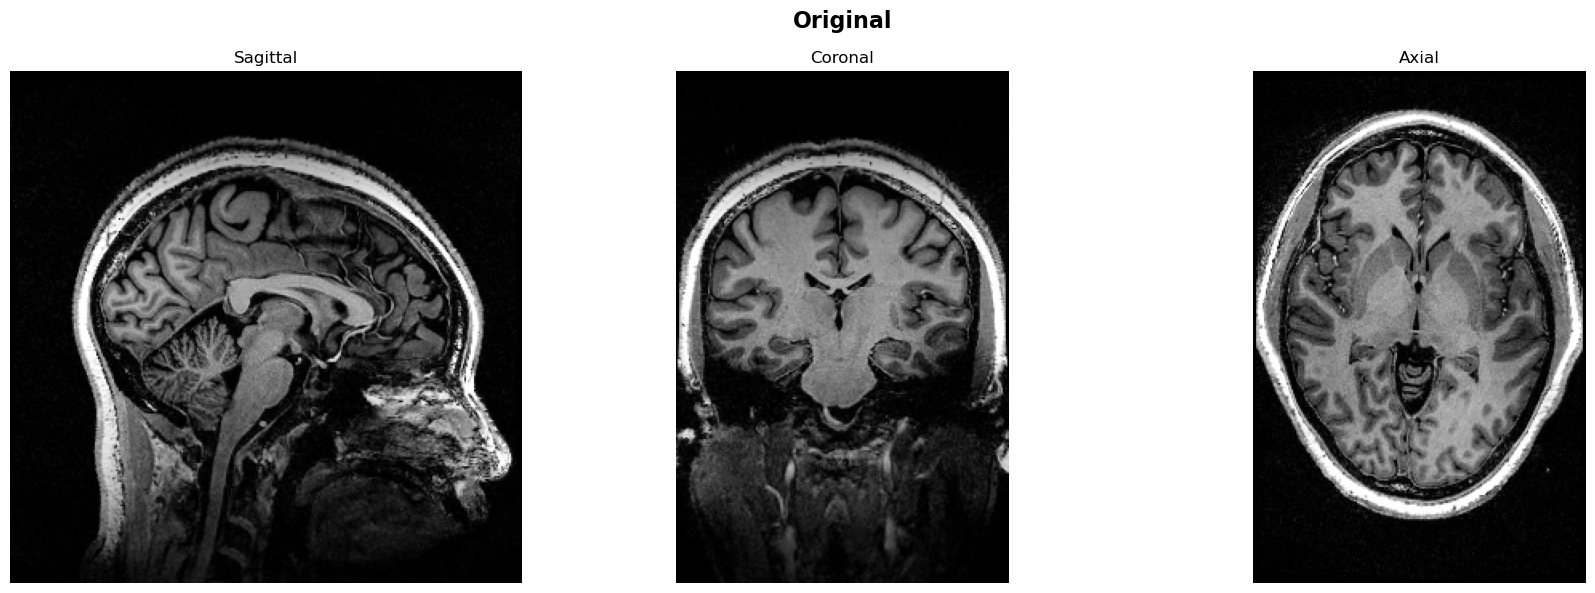

✅ Done


In [181]:
def load_mri(filepath):
    img = nib.load(filepath)
    data = img.get_fdata()
    print(f"Shape: {data.shape} | Voxel: {img.header.get_zooms()[:3]} | Orient: {''.join(nib.aff2axcodes(img.affine))}")
    return img, data

def visualize_slices(data, title="MRI"):
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    fig.suptitle(title, fontsize=16, fontweight='bold')
    mid = tuple(s//2 for s in data.shape)
    axes[0].imshow(data[mid[0], :, :].T, cmap='gray', origin='lower')
    axes[0].set_title('Sagittal'); axes[0].axis('off')
    axes[1].imshow(data[:, mid[1], :].T, cmap='gray', origin='lower')
    axes[1].set_title('Coronal'); axes[1].axis('off')
    axes[2].imshow(data[:, :, mid[2]].T, cmap='gray', origin='lower')
    axes[2].set_title('Axial'); axes[2].axis('off')
    plt.tight_layout(); plt.show()

print("=== SCRIPT 1 ===")
img, data = load_mri(SAMPLE_IMAGE_PATH)
visualize_slices(data, "Original")
print("✅ Done")

# SCRIPT 2: Reorientation

In [182]:
def reorient_to_standard(img, target='RAS'):
    current = io_orientation(img.affine)
    target_ornt = axcodes2ornt(target)
    transform = ornt_transform(current, target_ornt)
    data = nib.apply_orientation(img.get_fdata(), transform)
    affine = img.affine @ nib.orientations.inv_ornt_aff(transform, img.shape)
    return nib.Nifti1Image(data, affine)

print("=== SCRIPT 2 ===")
img_reoriented = reorient_to_standard(img)
nib.save(img_reoriented, OUTPUT_DIR / 'reoriented.nii.gz')
print(f"✅ Saved: {OUTPUT_DIR / 'reoriented.nii.gz'}")


=== SCRIPT 2 ===
✅ Saved: /Users/aazeez/Documents/Personal/ABDN_2025/content5/derivatives/reoriented.nii.gz


# SCRIPT 3: Bias Field Correction

=== SCRIPT 3 ===
Running N4...


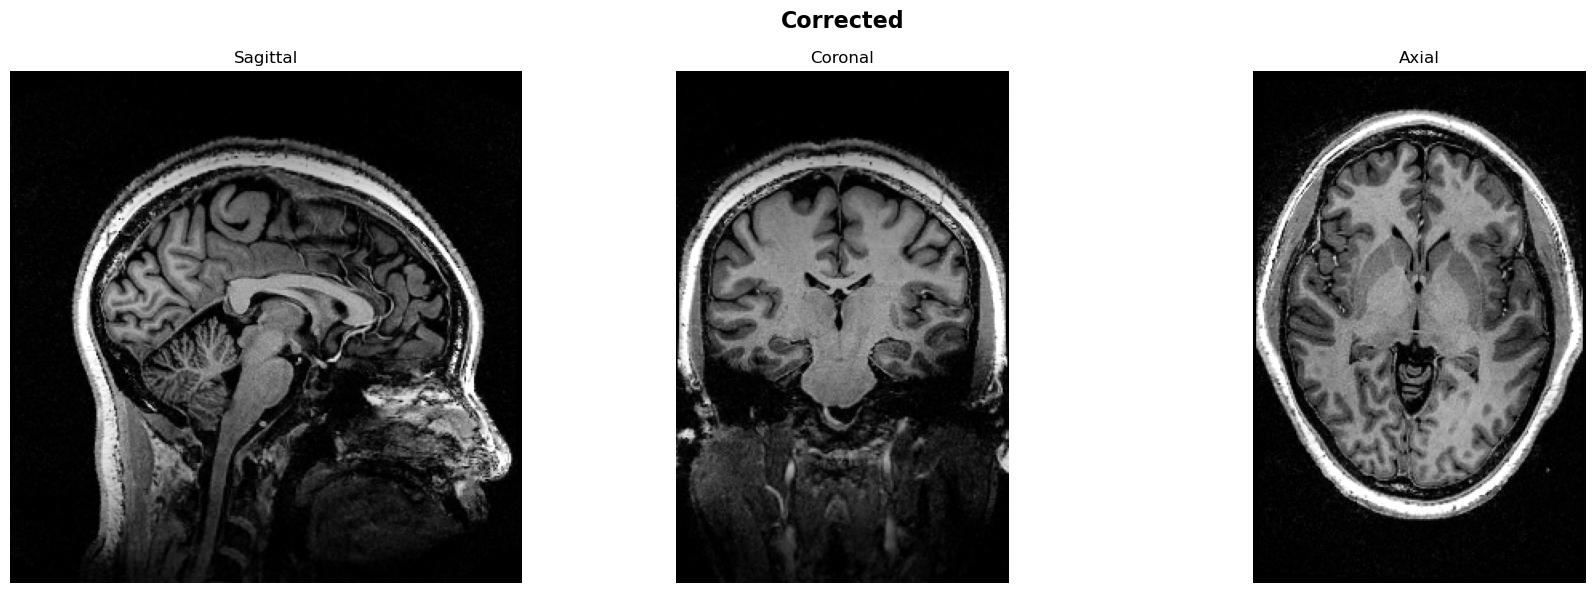

✅ Saved: /Users/aazeez/Documents/Personal/ABDN_2025/content5/derivatives/corrected.nii.gz


In [183]:
def n4_bias_correction(input_img):
    sitk_img = sitk.GetImageFromArray(input_img.get_fdata().T)
    sitk_img = sitk.Cast(sitk_img, sitk.sitkFloat32)
    corrector = sitk.N4BiasFieldCorrectionImageFilter()
    corrector.SetMaximumNumberOfIterations([50,50,50,50])
    corrected = corrector.Execute(sitk_img)
    data = sitk.GetArrayFromImage(corrected).T
    return nib.Nifti1Image(data, input_img.affine)

print("=== SCRIPT 3 ===")
print("Running N4...")
img_corrected = n4_bias_correction(img_reoriented)
nib.save(img_corrected, OUTPUT_DIR / 'corrected.nii.gz')
visualize_slices(img_corrected.get_fdata(), "Corrected")
print(f"✅ Saved: {OUTPUT_DIR / 'corrected.nii.gz'}")

# SCRIPT 4: Skull Stripping

=== SCRIPT 4 ===


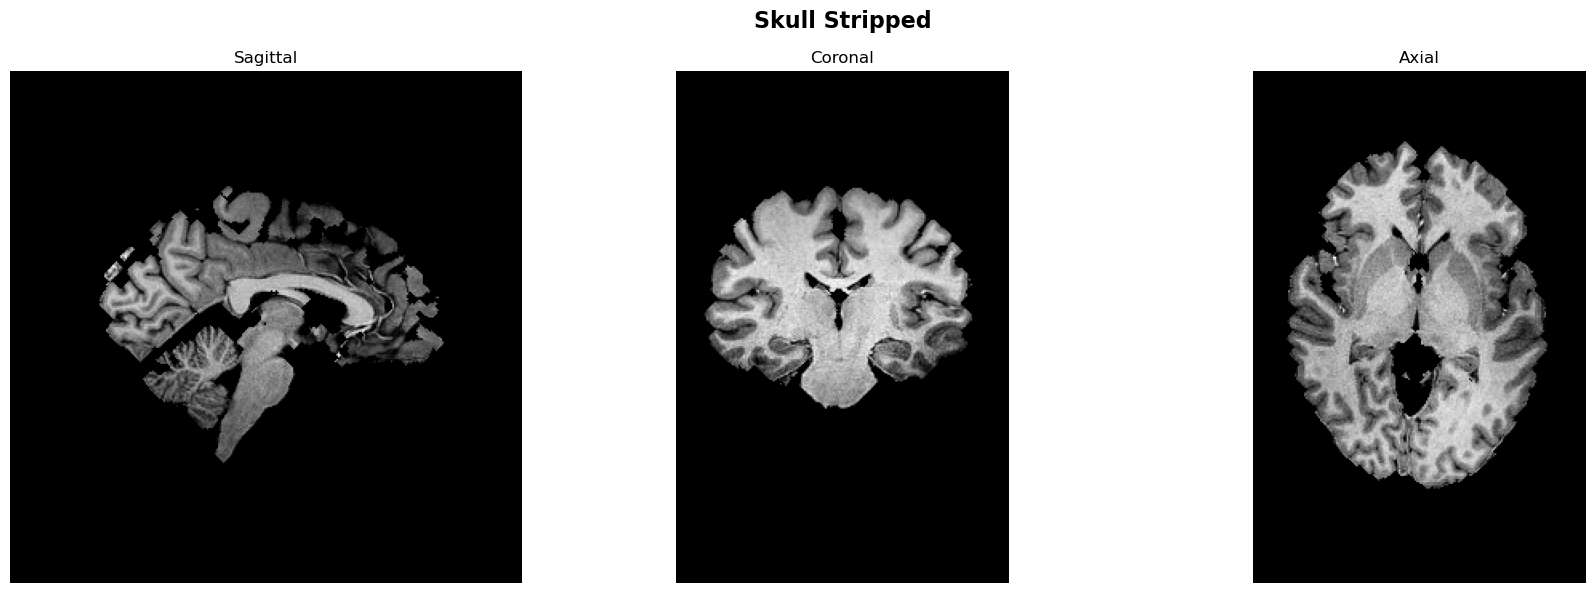

✅ Saved: /Users/aazeez/Documents/Personal/ABDN_2025/content5/derivatives/brain.nii.gz


In [232]:
def skull_strip(img, threshold_percentile=45):
    data = img.get_fdata()
    
    # Calculate threshold from non-zero values
    threshold = np.percentile(data[data > 0], threshold_percentile)
    
    # Create initial mask (brain tissue)
    mask = data > threshold
    
    # Erode to disconnect skull from brain
    mask = ndimage.binary_erosion(mask, iterations=6)
    
    # Remove small objects (noise and disconnected skull fragments)
    mask = morphology.remove_small_objects(mask, min_size=5000)
    
    # Keep only the largest connected component (the brain)
    labeled, num_features = ndimage.label(mask)
    if num_features > 0:
        sizes = ndimage.sum(mask, labeled, range(1, num_features + 1))
        max_label = np.argmax(sizes) + 1
        mask = labeled == max_label
    
    # Fill holes in the brain
    mask = ndimage.binary_fill_holes(mask)
    
    # Dilate back (but less than we eroded) to restore brain shape
    mask = ndimage.binary_dilation(mask, iterations=5)
    
    # Final smoothing
    mask = ndimage.binary_closing(mask, iterations=2)
    
    # Apply mask
    brain = data * mask
    
    return nib.Nifti1Image(brain, img.affine), nib.Nifti1Image(mask.astype(np.uint8), img.affine)

print("=== SCRIPT 4 ===")
img_brain, img_mask = skull_strip(img_corrected)
nib.save(img_brain, OUTPUT_DIR / 'brain.nii.gz')
nib.save(img_mask, OUTPUT_DIR / 'mask.nii.gz')
visualize_slices(img_brain.get_fdata(), "Skull Stripped")
print(f"✅ Saved: {OUTPUT_DIR / 'brain.nii.gz'}")

# SCRIPT 5: Registration to MNI

=== SCRIPT 5 ===
Registering to MNI...
Using nilearn (ANTsPy not available)


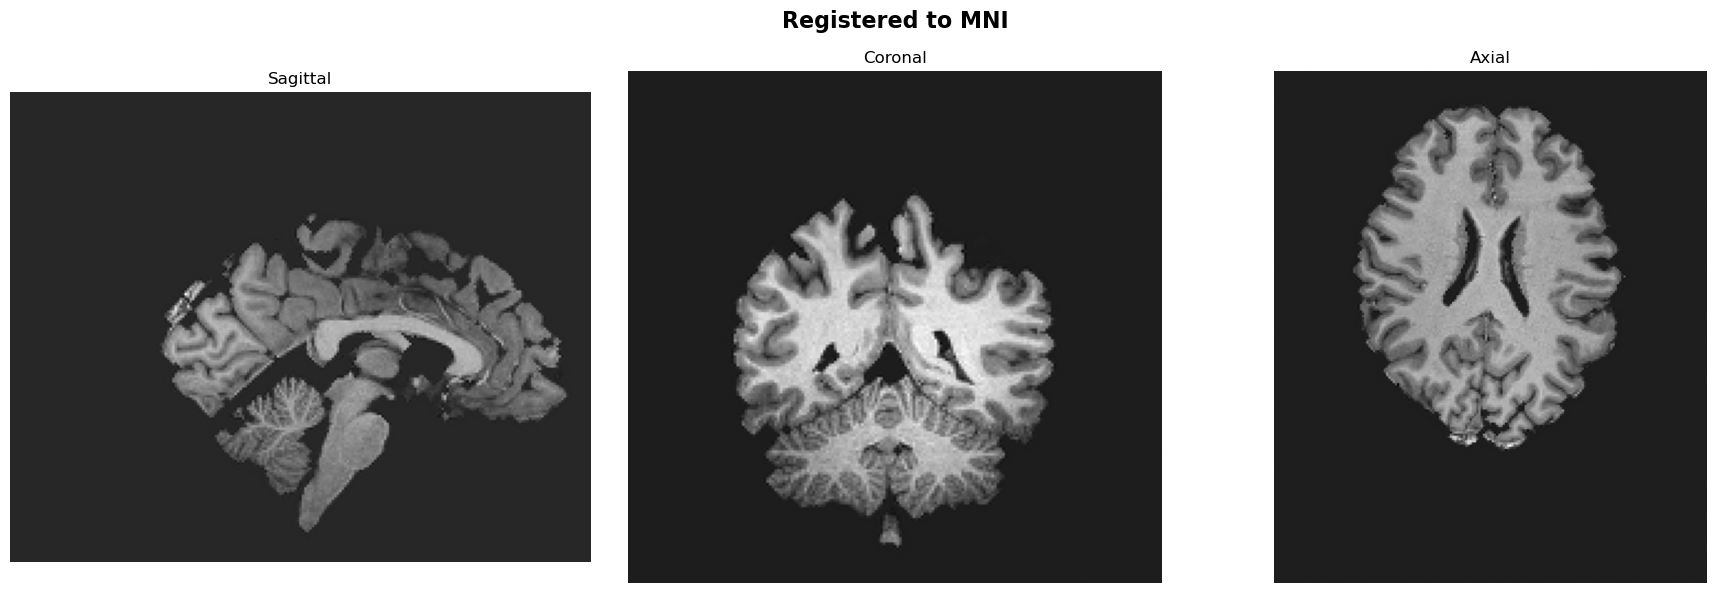

✅ Saved: /Users/aazeez/Documents/Personal/ABDN_2025/content5/derivatives/mni.nii.gz


In [233]:
def register_to_mni(moving_img):
    try:
        import ants
        moving = ants.from_nibabel(moving_img)
        fixed = ants.from_nibabel(mni_template)
        reg = ants.registration(fixed, moving, type_of_transform='Affine')
        return reg['warpedmovout'].to_nibabel()
    except:
        print("Using nilearn (ANTsPy not available)")
        return image.resample_to_img(moving_img, mni_template, interpolation='continuous')

print("=== SCRIPT 5 ===")
print("Registering to MNI...")
img_mni = register_to_mni(img_brain)
nib.save(img_mni, OUTPUT_DIR / 'mni.nii.gz')
visualize_slices(img_mni.get_fdata(), "Registered to MNI")
print(f"✅ Saved: {OUTPUT_DIR / 'mni.nii.gz'}")

# Summary

In [170]:
print("\n" + "="*60)
print("📊 PROCESSING COMPLETE - Scripts 1-5")
print("="*60)
print("\n✅ All files saved to:", OUTPUT_DIR)
print("\nGenerated files:")
for f in OUTPUT_DIR.glob('*.nii.gz'):
    print(f"  - {f.name}")
print("\n💡 Download files: Click folder icon (left) → derivatives → Download")
print("="*60)


📊 PROCESSING COMPLETE - Scripts 1-5

✅ All files saved to: /Users/aazeez/Documents/Personal/ABDN_2025/content4/derivatives

Generated files:
  - skull.nii.gz
  - brain_mask.nii.gz
  - mask.nii.gz
  - corrected.nii.gz
  - mni.nii.gz
  - reoriented.nii.gz
  - brain.nii.gz

💡 Download files: Click folder icon (left) → derivatives → Download
